This Jupyter Notebook contains a set of executions with different paraments, using the ```batch_run``` function that MESA provides, and the analysis of the results obtained. 

First, we start by importing the necessary libraries and dependencies.

In [1]:
import matplotlib.pyplot as plt
from model import EcosystemModel, EcosystemParameters, AgentParameters, PassiveAgentParameters
from mesa.batchrunner import batch_run
import numpy as np
import pandas as pd

Then we initialize the Ecosystem Parameters (i.e. all those who will be static in each batch run) and set the range of values for the number of predators, preys and vegetation. This gives us 8 runs because ```batch_run``` makes all the possible combinations (2 for predator amount, 2 for prey amount and 2 for vegetation amount = 2\*2\*2 = 8).

Then, we call the ```batch_run``` function with the model, the parameters, the number of iterations for each possible combination (1), the maximum number of steps to be performed in each iteration (1000), the number of processes (1 - using this number as it's recommended in the MESA documentation for Windows users), the data collection period (1, i.e. collect data at the end of each step of each iteration) and display progress (True).

In [2]:
ecosystem_params = EcosystemParameters(
    predator_parameters=AgentParameters(
        initial_energy_amount=10,
        energy_given_when_eaten=0, # doesn't matter, predators won't be eaten
        max_age=60,
        mating_timeout=10,
        min_energy_to_mate=8,
        energy_threshold_to_eat=10),
    prey_parameters=AgentParameters(
        initial_energy_amount=10,
        energy_given_when_eaten=10,
        max_age=75,
        mating_timeout=5,
        min_energy_to_mate=5,
        energy_threshold_to_eat=20),
    vegetation_parameters=PassiveAgentParameters(
        initial_energy_amount=10,
        energy_given_when_eaten=10),
    grid_width=20,
    grid_height=20)

params = {"parameters": ecosystem_params,
        "initial_predator_amount":range(5, 11, 5), 
        "initial_prey_amount":range(30, 41, 10),
        "initial_vegetation_amount":range(150, 201, 50)}

results = batch_run(
    EcosystemModel,
    parameters=params,
    iterations=1,
    max_steps=1000,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

8it [21:14, 159.35s/it]


Then, we convert the results to a pandas dataframe and print the keys, i.e. the column names.

In [3]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'parameters', 'initial_predator_amount',
       'initial_prey_amount', 'initial_vegetation_amount', 'predator_amount',
       'prey_amount', 'vegetation_amount', 'mean_predator_age',
       'mean_prey_age', 'mean_predator_energy', 'mean_prey_energy', 'AgentID',
       'type', 'energy'],
      dtype='object')


In order to keep the results permanently stored and accessible for further analysis, we save them in a csv file.

In [4]:
results_df.to_csv("results.csv")

Before moving on to the analysis of the data, we start by dividing the only dataframe we have into 8 dataframes, one for each iteration (i.e. environment configuration).

In [13]:
predator_values = results_df.initial_predator_amount.unique()
prey_values = results_df.initial_prey_amount.unique()
vegetation_values = results_df.initial_vegetation_amount.unique()

dataframes = []

for predator_value in predator_values:
    for prey_value in prey_values:
        for vegetation_value in vegetation_values:
            dataframes.append(results_df[(results_df.initial_predator_amount == predator_value) & (results_df.initial_prey_amount == prey_value) & (results_df.initial_vegetation_amount == vegetation_value)])
            
print(len(dataframes))


8


Then, we proceeed with the analysis by building up some graphics.

The first graphic is a bar plot with the maximum number of predators per iteration.
- x - iteration
- y - max_predator_amount

Max. Max. Predator Amount (all iterations): 253
Min. Max. Predator Amount (all iterations): 5


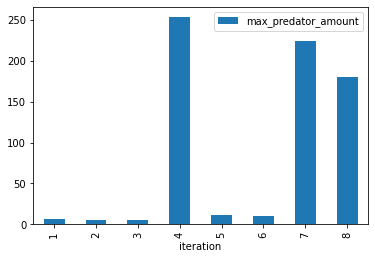

In [50]:
max = []

for df in dataframes:
    max.append(df.predator_amount.max())

max_predator = pd.DataFrame({"iteration": range(1,9,1), "max_predator_amount": max})

max_predator.plot.bar(x="iteration", y="max_predator_amount")

print("Max. Max. Predator Amount (all iterations): " + str(max_predator['max_predator_amount'].max()))
print("Min. Max. Predator Amount (all iterations): " + str(max_predator['max_predator_amount'].min()))

By analysing the graphic above, we can see that the maximum number of max. predators of all the iterations was 253 (iteration 4) and the minimum was 5 (iteration 2). Three of the 8 iterations had at a certain point more than 150 predators, while all the others never had more than 50 predators.

Note:

- Iteration 2: initial number of predators = 5; initial number of preys = 30 
- Iteration 4: initial number of predators = 5; initial number of preys = 40
- Number of vegetation equal to both: 200

The second graphic is similar to the one above, but for the maximum number of pray per iteration
- x - iteration
- y - max_prey_amount

Max. Max. Prey Amount (all iterations): 3297
Min. Max. Prey Amount (all iterations): 476


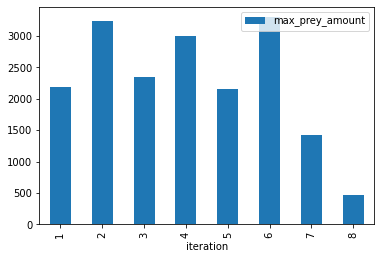

In [51]:
max = []

for df in dataframes:
    max.append(df.prey_amount.max())

max_prey = pd.DataFrame({"iteration": range(1,9,1), "max_prey_amount": max})

max_prey.plot.bar(x="iteration", y="max_prey_amount")

print("Max. Max. Prey Amount (all iterations): " + str(max_prey['max_prey_amount'].max()))
print("Min. Max. Prey Amount (all iterations): " + str(max_prey['max_prey_amount'].min()))

The results here are more balanced. The maximum number of max. preys was achieved on iteration 6 (3297) and the minimum number of max. preys on iteration 8 (476).

Note:

- Iteration 6: initial number of predators = 10; initial number of preys = 30
- Iteration 8: initial number of predators = 10; initial number of preys = 40
- Number of vegetation equal to both: 200

One interesting conclusion of the analysis of these graphics is that the maximum and minimum values for predator and prey occur for the same number of initial predators and different number of inital preys.

Now, the third analysis is a table that shows the number of steps per iteration.

In [52]:
steps = []

for df in dataframes:
    steps.append(df.Step.max())

num_steps = pd.DataFrame({"iteration": range(1,9,1), "num_steps": steps})

print(num_steps.to_string(index=False, columns=["iteration", "num_steps"]))

 iteration  num_steps
         1       1000
         2       1000
         3       1000
         4        277
         5       1000
         6       1000
         7        234
         8        180


We can conclude from above that only 3 iteration didn't reach the step limit established in the beggining.

The fourth graphic (and corresponding table) combines the graphics 1 and 2, i.e. shows the max. number of preys and predators per iteration
- x - iteration
- y - 2 lines (1 f/ max_prey_amount + 1 f/ max_predator_amount)

 iteration  max_prey_amount  max_predator_amount
         1             2181                    7
         2             3239                    5
         3             2341                    6
         4             3006                  253
         5             2152                   11
         6             3297                   10
         7             1424                  224
         8              476                  180


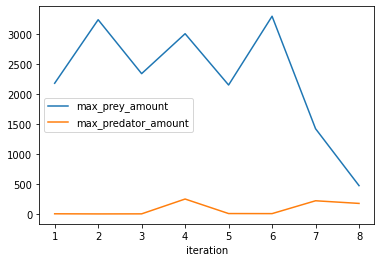

In [53]:
max_predator_val = []
max_prey_val = []

for df in dataframes:
    max_prey_val.append(df.prey_amount.max())
    max_predator_val.append(df.predator_amount.max())

max_prey_predator = pd.DataFrame({"iteration": range(1,9,1), "max_prey_amount": max_prey_val, "max_predator_amount": max_predator_val})

max_prey_predator.plot.line(x='iteration', y=['max_prey_amount', 'max_predator_amount'])

print(max_prey_predator.to_string(index=False))

From the code above, we can conclude pretty much the same we concluded above.

Now, the graphic 5 is equal to the graphic 1 but f/ the energy, instead of the amount of predators.

Max. Max. Predator Energy (all iterations): 414.0
Min. Max. Predator Energy (all iterations): 73.265625


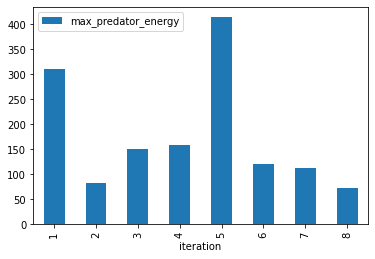

In [62]:
max = []

for df in dataframes:
    max.append(df.mean_predator_energy.max())

max_predator_e = pd.DataFrame({"iteration": range(1,9,1), "max_predator_energy": max})

max_predator_e.plot.bar(x="iteration", y="max_predator_energy")

print("Max. Max. Predator Energy (all iterations): " + str(max_predator_e['max_predator_energy'].max()))
print("Min. Max. Predator Energy (all iterations): " + str(max_predator_e['max_predator_energy'].min()))

Again, a vary unbalanced graphic that shows that iterations 1 and 5 (same value for preys and vegetation, 30 and 150, respectively, but different for predator, 5 and 10) were the ones with highest values of achieved energy, while iteration 2 (preys = 5, predators = 30, vegetation = 200) and 8 (preys = 10, predators = 40, vegetation = 200) were the lower ones in terms of energy.

This graphic is equal to the one above, but for the preys.

Max. Max. Prey Energy (all iterations): 35.041666666666664
Min. Max. Prey Energy (all iterations): 28.547619047619047


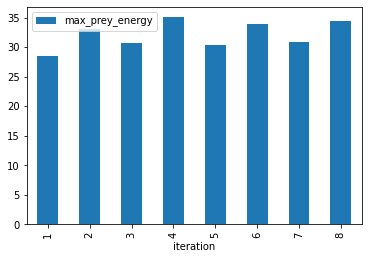

In [63]:
max = []

for df in dataframes:
    max.append(df.mean_prey_energy.max())

max_prey_e = pd.DataFrame({"iteration": range(1,9,1), "max_prey_energy": max})

max_prey_e.plot.bar(x="iteration", y="max_prey_energy")

print("Max. Max. Prey Energy (all iterations): " + str(max_prey_e['max_prey_energy'].max()))
print("Min. Max. Prey Energy (all iterations): " + str(max_prey_e['max_prey_energy'].min()))

Again, like for the amount, we can see that preys have more balanced values of energy over the iterations, with the maximum and minimum really close to each other in comparison with the difference registered for the predators.

Now, combining the max. registered values for the energy of preys and predators in each iteration, we obtain the following graphic (and corresponding table):

 iteration  max_prey_energy  max_predator_energy
         1        28.547619           311.000000
         2        33.050000            83.500000
         3        30.653061           151.000000
         4        35.041667           159.111111
         5        30.285714           414.000000
         6        33.925926           121.000000
         7        30.794872           111.970588
         8        34.440678            73.265625


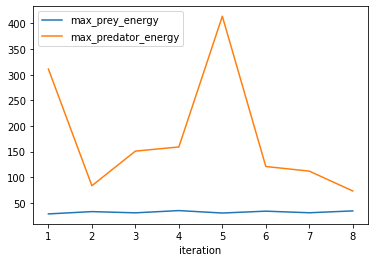

In [58]:
max_predator_e = []
max_prey_e = []

for df in dataframes:
    max_prey_e.append(df.mean_prey_energy.max())
    max_predator_e.append(df.mean_predator_energy.max())

max_prey_predator_e = pd.DataFrame({"iteration": range(1,9,1), "max_prey_energy": max_prey_e, "max_predator_energy": max_predator_e})

max_prey_predator_e.plot.line(x='iteration', y=['max_prey_energy', 'max_predator_energy'])

print(max_prey_predator_e.to_string(index=False))

The conclusions are the same as the above two previous graphics.

This 8th graphic is the same as the 1st and 5th, but now for the max. predator age.

Max. Max. Predator Age (all iterations): 60.0
Min. Max. Predator Age (all iterations): 47.0


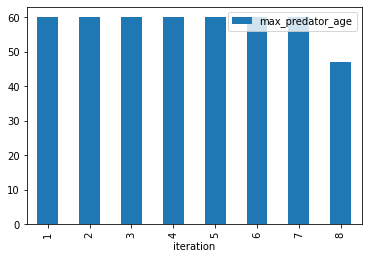

In [64]:
max = []

for df in dataframes:
    max.append(df.mean_predator_age.max())

max_prey_a = pd.DataFrame({"iteration": range(1,9,1), "max_predator_age": max})

max_prey_a.plot.bar(x="iteration", y="max_predator_age")

print("Max. Max. Predator Age (all iterations): " + str(max_prey_a['max_predator_age'].max()))
print("Min. Max. Predator Age (all iterations): " + str(max_prey_a['max_predator_age'].min()))

Unlike the amount and energy, for the age, the max. values for the predators are similar over the iterations. Let's see if the same happens for the preys.

Max. Max. Prey Age (all iterations): 30.0
Min. Max. Prey Age (all iterations): 14.482649842271293


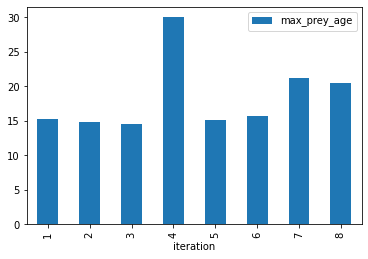

In [65]:
max = []

for df in dataframes:
    max.append(df.mean_prey_age.max())

max_prey_a = pd.DataFrame({"iteration": range(1,9,1), "max_prey_age": max})

max_prey_a.plot.bar(x="iteration", y="max_prey_age")

print("Max. Max. Prey Age (all iterations): " + str(max_prey_a['max_prey_age'].max()))
print("Min. Max. Prey Age (all iterations): " + str(max_prey_a['max_prey_age'].min()))

Despite the iteration 4 having a value that's completely different from all the others, the max. age value of the preys over the iterations is balanced too.

This graphic, like we made above, shows the combination of the two above graphics.

 iteration  max_prey_age  max_predator_age
         1     15.324841              60.0
         2     14.776860              60.0
         3     14.482650              60.0
         4     30.000000              60.0
         5     15.154882              60.0
         6     15.658537              60.0
         7     21.250000              60.0
         8     20.555556              47.0


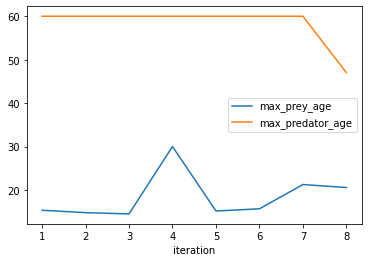

In [66]:
max_predator_a = []
max_prey_a = []

for df in dataframes:
    max_prey_a.append(df.mean_prey_age.max())
    max_predator_a.append(df.mean_predator_age.max())

max_prey_predator_a = pd.DataFrame({"iteration": range(1,9,1), "max_prey_age": max_prey_a, "max_predator_age": max_predator_a})

max_prey_predator_a.plot.line(x='iteration', y=['max_prey_age', 'max_predator_age'])

print(max_prey_predator_a.to_string(index=False))

The conclusions are the same as above.

Finally, we include here a set of line graphics, one for each iteration, were we show the number of predators and preys on each step.

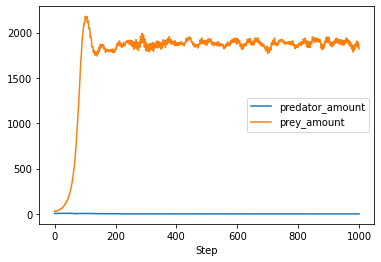

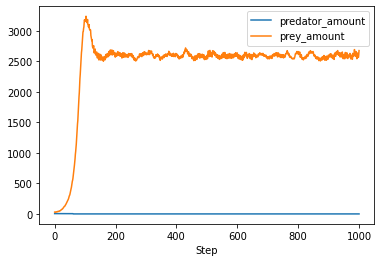

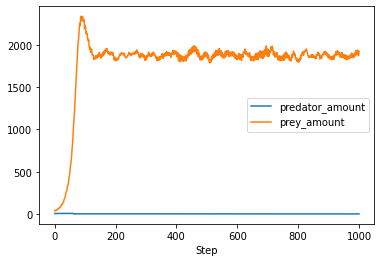

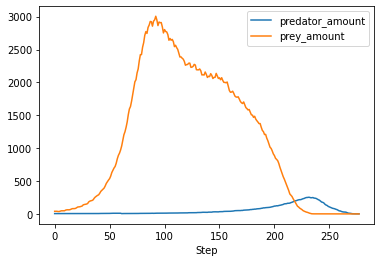

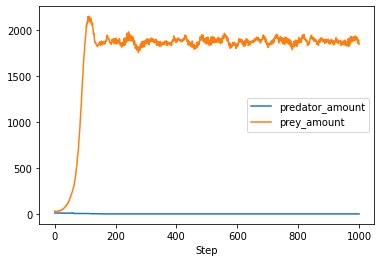

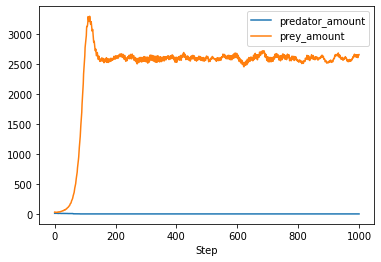

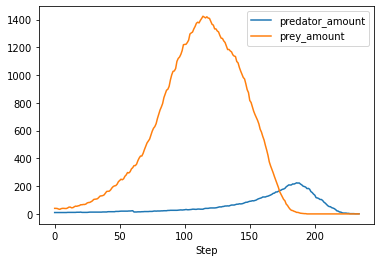

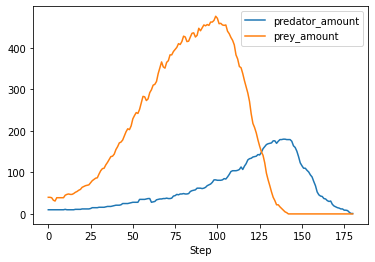

In [47]:
shorter_df = []

for df in dataframes:
    shorter_df.append(df[['Step', 'predator_amount', 'prey_amount']])

for sdf in shorter_df:
    sdf.plot.line(x='Step', y=['predator_amount', 'prey_amount'])